<a href="https://colab.research.google.com/github/minette3762/FundDeepPyTorch/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP in SciML
This code inspired from the lecture note `kks32-courses.github.io`

## 1D Poisson Equation
Consider Poisson Equation
$$-\dfrac{d^2u}{dx^2}=f(x),\quad u(0)=u(1)=0$$
with $f(x)=\pi^2\sin(\pi x)$.

The exact solution of this equation is $u(x)=\sin(\pi x)$.

In [1]:
# setup
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random

SEED = 4321
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Set up plotting style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

### Function approximation

In [8]:
# Make a random sample point
numpoint = 10
x_train = np.random.rand(numpoint)
x_train[0] = 0
x_train[-1] = 1
x_train = np.sort(x_train)

In [9]:
x_train

array([0.        , 0.04232059, 0.23223995, 0.34229612, 0.37548586,
       0.43007546, 0.66477708, 0.92991787, 0.94837513, 1.        ])

In [4]:
# Exact solution
def exact_solution(x):
  return np.sin(np.pi*x)

In [14]:
# Add noise
y_train = exact_solution(x_train)+0.01*np.random.randn(numpoint)

x_test = np.linspace(0,1,100)
y_exact = exact_solution(x_test)

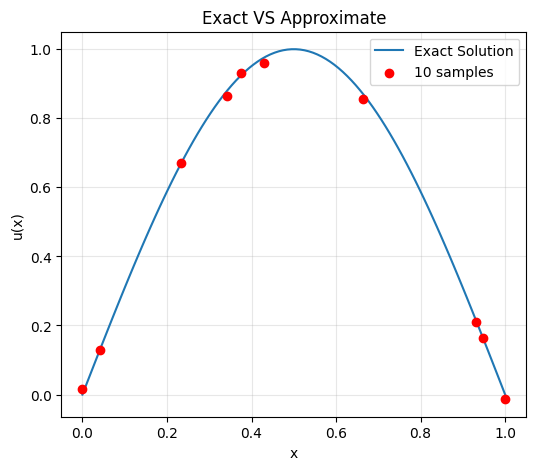

In [23]:
# Visualize the graph
plt.figure(figsize=(6,5))
plt.plot(x_test, y_exact,label='Exact Solution')
plt.scatter(x_train, y_train, c = 'red', zorder=2, label = f'{numpoint} samples')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('Exact VS Approximate')
plt.show()

### Polynomial Approximation


> Train MSE decreases while max error incrases

**This method is not appropraite to approximate the solution!**



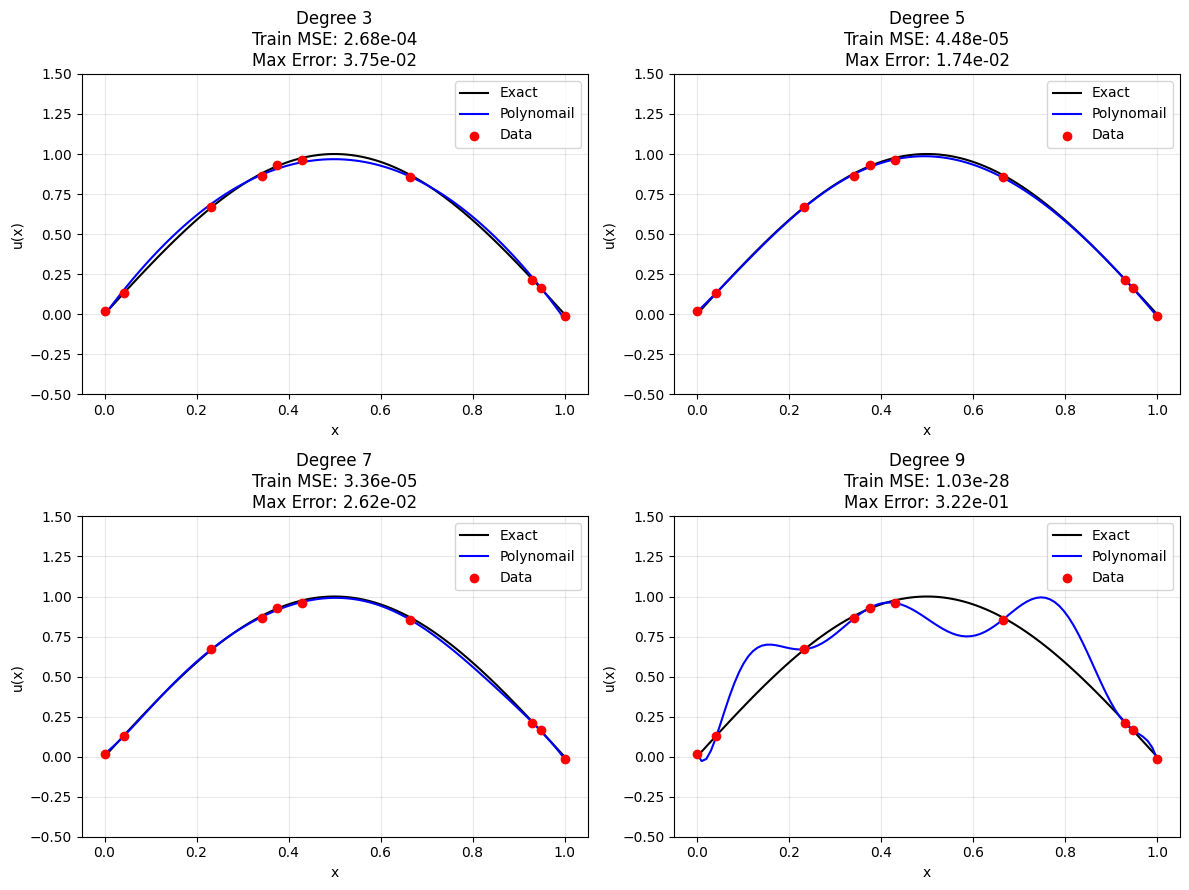

In [18]:
from numpy.polynomial import Polynomial

# Vary the degree
degs = [3,5,7,9]
poly_models = {}
errors = {}

fig, axes = plt.subplots(2, 2, figsize = (12,9))

for idx, degree in enumerate(degs):
  # Fit data
  poly = Polynomial.fit(x_train, y_train, degree)
  y_poly = poly(x_test)
  poly_models[f'Poly-{degree}'] = y_poly

  # Find errors
  train_mse = np.mean((poly(x_train) - y_train)**2)
  test_error = np.max(np.abs(y_poly - y_exact))
  errors[degree] = {'train_mse':train_mse, 'test_error':test_error}

  # Visulaize
  ax = axes[idx // 2, idx % 2] # Corrected line: use 2D indexing for axes
  ax.plot(x_test, y_exact, 'k-', label = 'Exact')
  ax.plot(x_test, y_poly, 'b-', label = 'Polynomail')
  ax.scatter(x_train, y_train, c = 'red', zorder=2, label = 'Data')
  ax.set_xlabel('x')
  ax.set_ylabel('u(x)')
  ax.set_title(f'Degree {degree}\nTrain MSE: {train_mse:.2e}\nMax Error: {test_error:.2e}')
  ax.legend()
  ax.set_ylim([-0.5, 1.5])

plt.tight_layout()
plt.show()

### Finite Difference Method

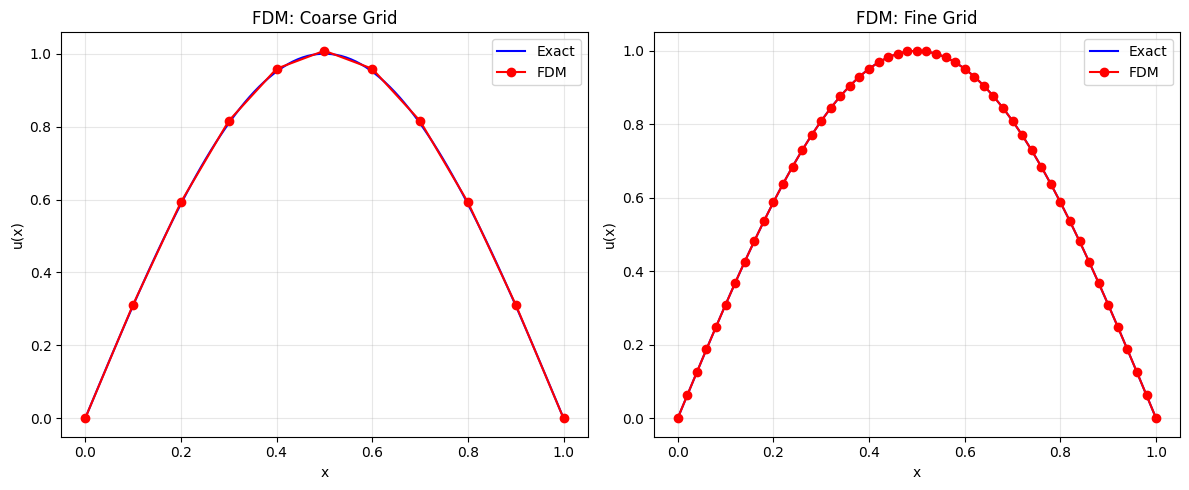

In [31]:
def source(x):
  return np.pi**2*np.sin(np.pi*x)

def fdm(numpoints = 101):
  # Grid
  x_fdm = np.linspace(0, 1, numpoints)
  h = 1.0/(numpoints-1)

  # central difference
  interiorpoint = numpoints-2
  A = np.zeros((interiorpoint, interiorpoint))
  np.fill_diagonal(A, 2.0/h**2)
  np.fill_diagonal(A[1:,:], -1.0/h**2)
  np.fill_diagonal(A[:,1:], -1.0/h**2)

  # RHS
  rhs = source(x_fdm[1:-1])

  # Solve Au = f
  interioru = np.linalg.solve(A, rhs)

  # Add boundary conditions
  u_fdm = np.zeros(numpoints)
  u_fdm[0] = 0
  u_fdm[-1] = 0
  u_fdm[1:-1] = interioru

  return x_fdm, u_fdm

x_fdm_coarse, u_fdm_course = fdm(11)
x_fdm_fine, u_fdm_fine = fdm(51)

# Visualization
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(x_test, y_exact, 'b-', label = 'Exact')
ax1.plot(x_fdm_coarse, u_fdm_course, 'ro-', label = 'FDM')
ax1.set_xlabel('x')
ax1.set_ylabel('u(x)')
ax1.set_title('FDM: Coarse Grid')
ax1.legend()
ax1.grid(True)

ax2.plot(x_test, y_exact, 'b-', label = 'Exact')
ax2.plot(x_fdm_fine, u_fdm_fine, 'ro-', label = 'FDM')
ax2.set_xlabel('x')
ax2.set_ylabel('u(x)')
ax2.set_title('FDM: Fine Grid')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [35]:
error_coarse = np.max(np.abs(u_fdm_course-exact_solution(x_fdm_coarse)))
print(error_coarse)

0.008265416966228845


In [36]:
error_fine = np.max(np.abs(u_fdm_fine-exact_solution(x_fdm_fine)))
print(error_fine)

0.0003290517629341849


In [38]:
print(error_coarse/error_fine)

25.118895861627845
